In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from pathlib import Path
import numpy as np
import pandas as pd
import random, getopt, os, sys, json

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *
from Lamp.Model.BaseModel import *
from Lamp.Model.ResNet import *

In [3]:
def set_seed(seed):
    """ Set the random seed """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input, label = data
                input = input.to(self.device)

                output = self.net(input)

                labels += list(output.cpu().data.tolist())
            
        return labels

In [4]:
ifile = "../Models/config/MAR_RESNET18_PADDED_256_ALL_NEW.yaml"

inputs = load_config(ifile)
seed = int(inputs.Seed)
layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
classes = inputs.Model.OutClasses
channels = inputs.Model.Channels
n_samples = inputs.NSamples

# Handle file paths
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
path_load_data = f"{root_path}/{inputs.LoadPath}" # Path for the .csv file

# Seed
set_seed(seed)

# Pytorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce 940MX


In [5]:
# Train Data : 
train_dataframe = pd.read_csv(f"{root_path}/{inputs.LoadPath}",index_col=0)
# Test Data Borehole :
test_dataframe = pd.read_csv(f"{root_path}/{inputs.LoadPathTestBorehole}",index_col=0)
test_dataframe['Type'] = 'Test'

# Train Test Split
train_dataframe, _ = train_test_split(train_dataframe, test_size=(1 - inputs.TrainTestSplit),stratify=train_dataframe['Label'], random_state=inputs.Seed)
# Reset Index
train_dataframe = train_dataframe.reset_index(drop=True)
# Samples
train_dataframe = train_dataframe.groupby('Label').sample(n_samples,replace=True,random_state=inputs.Seed).reset_index(drop=True)
train_dataframe['Type'] = 'Train'

dataframe_tot = pd.concat([train_dataframe,test_dataframe],ignore_index=True) # Store global, train/test and per class tsne location

In [6]:
dict_transform = {
    "Padding":Padding,
    "VerticalFlip":tf.RandomVerticalFlip,
    "HorizontalFlip":tf.RandomHorizontalFlip,
    "Rotation":tf.RandomRotation,
    "CenterCrop":tf.CenterCrop,
    "Resize":tf.Resize,
    }

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

net = resnet(layers=layers,channels=channels,num_classes=classes)

classifier = Classifier(
        net=net, 
        device=device
        )

model_name = f"model_all.pt"
save_model_path = f"{path_model}/{model_name}"

# Load trained model
classifier.load(save_model_path)

# Update trained model to output output after avg pool and before final linear
classifier.net = torch.nn.Sequential(*(list(classifier.net.children())[:-1]))

In [7]:
trainDataset = Dataset(
    train_dataframe.reset_index(drop=True),
    transforms=transforms_test.get_transforms()
    )

train_dataloader = torch.utils.data.DataLoader(
    trainDataset, 
    batch_size=4,
    shuffle=False
    )

testDataset = Dataset(
    test_dataframe.reset_index(drop=True),
    transforms=transforms_test.get_transforms()
    )

test_dataloader = torch.utils.data.DataLoader(
    testDataset, 
    batch_size=4,
    shuffle=False
    )

output_train = classifier.predict(train_dataloader)
output_test = classifier.predict(test_dataloader)

In [8]:
data_all = np.concatenate([np.asarray(output_train)[:,:,0,0], np.asarray(output_test)[:,:,0,0]],axis=0)

In [9]:
### Global ###
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(data_all)

dataframe_tot['TSNE_Global_1'], dataframe_tot['TSNE_Global_2'] = tsne_data[:,0], tsne_data[:,1]

### Train/Test ###

# Train
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
tsne_data_train = model.fit_transform(np.asarray(output_train)[:,:,0,0])

# Test
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
tsne_data_test = model.fit_transform(np.asarray(output_test)[:,:,0,0])

tsne_data_train_test = np.concatenate([tsne_data_train, tsne_data_test],axis=0)

dataframe_tot['TSNE_Train_Test_1'], dataframe_tot['TSNE_Train_Test_2'] = tsne_data_train_test[:,0], tsne_data_train_test[:,1]


In [10]:
import itertools

output_train = np.asarray(output_train)[:,:,0,0]
output_test = np.asarray(output_test)[:,:,0,0]

In [11]:
for type_, rock_ in itertools.product(['Train','Test'],[0,1,2,3,4]):
    print(f"{type_} {rock_}")

    if type_ is 'Train':
        model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
        tsne_data = model.fit_transform(output_train[train_dataframe.loc[train_dataframe.Label == rock_,:].index.values])
    
    else : # Output 'Test'
        model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
        tsne_data = model.fit_transform(output_test[test_dataframe.loc[test_dataframe.Label == rock_,:].index.values])

    dataframe_tot.loc[(dataframe_tot.Type == type_) & (dataframe_tot.Label == rock_),'TSNE_Rock_1'] = tsne_data[:,0]
    dataframe_tot.loc[(dataframe_tot.Type == type_) & (dataframe_tot.Label == rock_),'TSNE_Rock_2'] = tsne_data[:,1]

    

Train 0
Train 1
Train 2
Train 3
Train 4
Test 0
Test 1
Test 2
Test 3
Test 4


In [12]:
dataframe_tot

,Paths,Label,Type,TSNE_Global_1,TSNE_Global_2,TSNE_Train_Test_1,TSNE_Train_Test_2,TSNE_Rock_1,TSNE_Rock_2
0,../Data/Train/BL3-5-DL\slice01040 (2020_05_17 ...,0,Train,-28.760246,-73.888290,7.243178,-47.103519,4.815847,-0.906760
1,../Data/Train/BL3-5-DL\slice01110 (2020_05_17 ...,0,Train,-57.116589,-39.888035,10.153441,-39.466187,7.931582,6.883246
2,../Data/Train/BL3-5-DL\slice00910 (2020_05_17 ...,0,Train,-95.329475,-40.514091,0.628613,-69.007767,-1.066710,-26.369139
3,../Data/Train/BL3-1-DL\slice00400 (2020_05_17 ...,0,Train,-101.298637,-33.308884,-7.479614,-61.450542,-10.042993,-23.245953
4,../Data/Train/BL3-1-DL\slice00380 (2020_05_17 ...,0,Train,-65.153419,-50.168648,15.911641,-42.830013,15.764511,3.944562
...,...,...,...,...,...,...,...,...,...
10791,../Data/Test_Borehole/OL-DB-3\slice00840_mar_r...,4,Test,-49.767624,-6.138916,25.001099,39.974808,23.821077,12.417697
10792,../Data/Test_Borehole/OL-DB-3\slice00840_mar_r...,4,Test,22.829527,-6.315372,15.735489,-11.781265,21.136478,-13.349015
10793,../Data/Test_Borehole/OL-DB-3\slice00850_mar_r...,4,Test,-33.175396,57.040550,-36.037079,15.885207,-30.048313,-3.154742
10794,../Data/Test_Borehole/OL-DB-3\slice00850_mar_r...,4,Test,19.119305,11.383455,-12.674751,-12.630099,-2.298069,-7.796171


In [13]:
import matplotlib.pyplot as plt

(array([-150., -100.,  -50.,    0.,   50.,  100.,  150.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

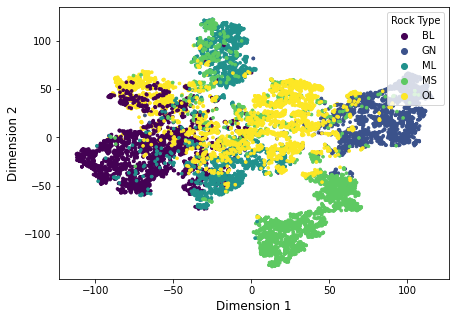

In [14]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(dataframe_tot['TSNE_Global_1'],dataframe_tot['TSNE_Global_2'],c=dataframe_tot.Label.values,s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('BL')
legend1.get_texts()[1].set_text('GN')
legend1.get_texts()[2].set_text('ML')
legend1.get_texts()[3].set_text('MS')
legend1.get_texts()[4].set_text('OL')
plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [46]:
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

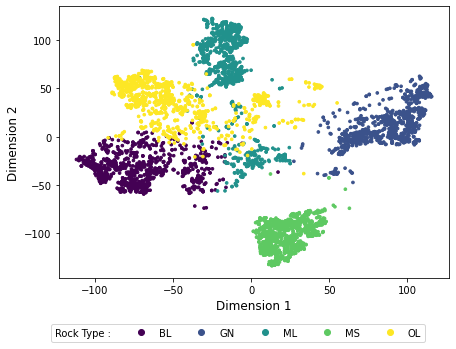

In [54]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[dataframe_tot['Type']=='Train','TSNE_Global_1'],
    dataframe_tot.loc[dataframe_tot['Type']=='Train','TSNE_Global_2'],
    c=dataframe_tot.loc[dataframe_tot['Type']=='Train','Label'].values,
    s=7)

legend1 = ax.legend(*scatter.legend_elements(),
                    bbox_to_anchor=(0.95,-0.15),ncol=5, title="Rock Type :",fontsize=10)
legend_title_left(legend1)

legend1.get_texts()[0].set_text('BL')
legend1.get_texts()[1].set_text('GN')
legend1.get_texts()[2].set_text('ML')
legend1.get_texts()[3].set_text('MS')
legend1.get_texts()[4].set_text('OL')
plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('../FiguresPaper/tnse_train.png',bbox_inches='tight')

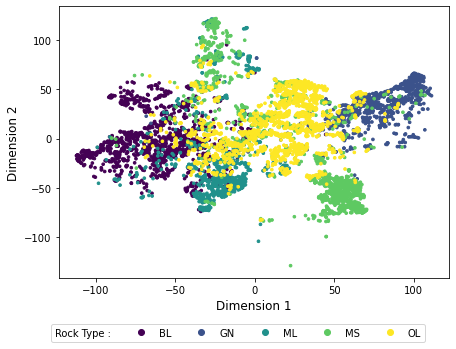

In [55]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[dataframe_tot['Type']=='Test','TSNE_Global_1'],
    dataframe_tot.loc[dataframe_tot['Type']=='Test','TSNE_Global_2'],
    c=dataframe_tot.loc[dataframe_tot['Type']=='Test','Label'].values,
    s=7)

legend1 = ax.legend(*scatter.legend_elements(),
                    bbox_to_anchor=(0.95,-0.15),ncol=5, title="Rock Type :",fontsize=10)
legend_title_left(legend1)

legend1.get_texts()[0].set_text('BL')
legend1.get_texts()[1].set_text('GN')
legend1.get_texts()[2].set_text('ML')
legend1.get_texts()[3].set_text('MS')
legend1.get_texts()[4].set_text('OL')
plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('../FiguresPaper/tnse_test.png',bbox_inches='tight')

(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.,
         125.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

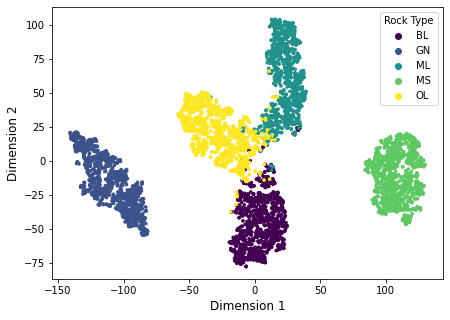

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[dataframe_tot['Type']=='Train','TSNE_Train_Test_1'],
    dataframe_tot.loc[dataframe_tot['Type']=='Train','TSNE_Train_Test_2'],
    c=dataframe_tot.loc[dataframe_tot['Type']=='Train','Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('BL')
legend1.get_texts()[1].set_text('GN')
legend1.get_texts()[2].set_text('ML')
legend1.get_texts()[3].set_text('MS')
legend1.get_texts()[4].set_text('OL')
plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.,
         125.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

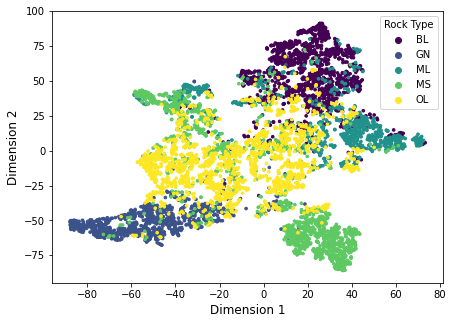

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[dataframe_tot['Type']=='Test','TSNE_Train_Test_1'],
    dataframe_tot.loc[dataframe_tot['Type']=='Test','TSNE_Train_Test_2'],
    c=dataframe_tot.loc[dataframe_tot['Type']=='Test','Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('BL')
legend1.get_texts()[1].set_text('GN')
legend1.get_texts()[2].set_text('ML')
legend1.get_texts()[3].set_text('MS')
legend1.get_texts()[4].set_text('OL')
plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-50., -40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

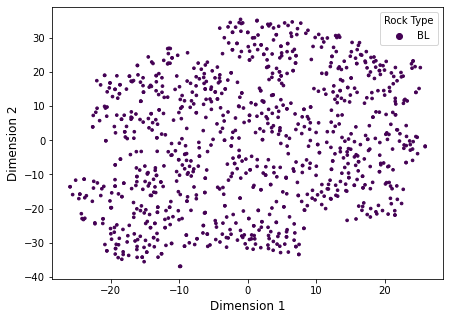

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[(dataframe_tot['Type']=='Train') & (dataframe_tot['Label']==0),'TSNE_Rock_1'],
    dataframe_tot.loc[(dataframe_tot['Type']=='Train') & (dataframe_tot['Label']==0),'TSNE_Rock_2'],
    c=dataframe_tot.loc[(dataframe_tot['Type']=='Train') & (dataframe_tot['Label']==0),'Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('BL')

plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

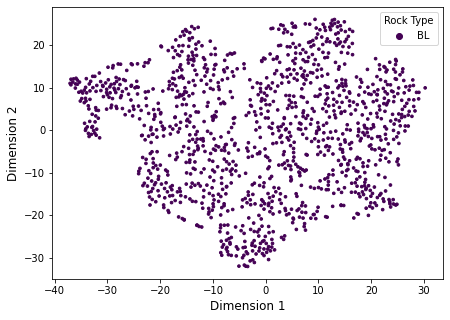

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==0),'TSNE_Rock_1'],
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==0),'TSNE_Rock_2'],
    c=dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==0),'Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('BL')

plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-30., -20., -10.,   0.,  10.,  20.,  30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

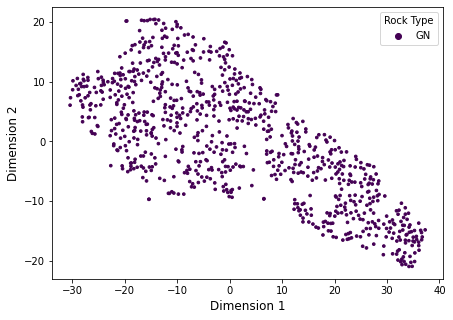

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==1),'TSNE_Rock_1'],
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==1),'TSNE_Rock_2'],
    c=dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==1),'Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('GN')

plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

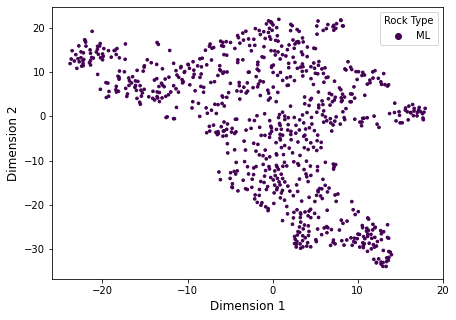

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==2),'TSNE_Rock_1'],
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==2),'TSNE_Rock_2'],
    c=dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==2),'Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('ML')

plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-50., -40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

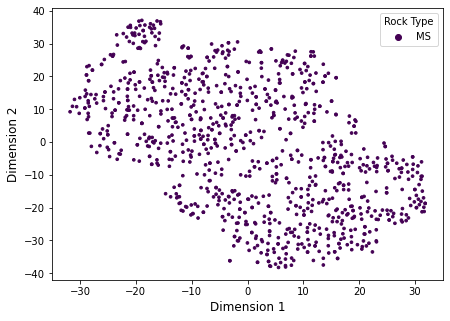

In [23]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[(dataframe_tot['Type']=='Train') & (dataframe_tot['Label']==3),'TSNE_Rock_1'],
    dataframe_tot.loc[(dataframe_tot['Type']=='Train') & (dataframe_tot['Label']==3),'TSNE_Rock_2'],
    c=dataframe_tot.loc[(dataframe_tot['Type']=='Train') & (dataframe_tot['Label']==3),'Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('MS')

plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-30., -20., -10.,   0.,  10.,  20.,  30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

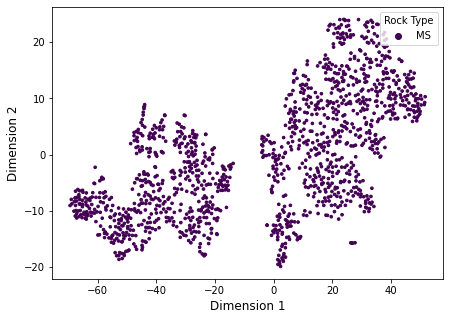

In [24]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==3),'TSNE_Rock_1'],
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==3),'TSNE_Rock_2'],
    c=dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==3),'Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('MS')

plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([-50., -40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

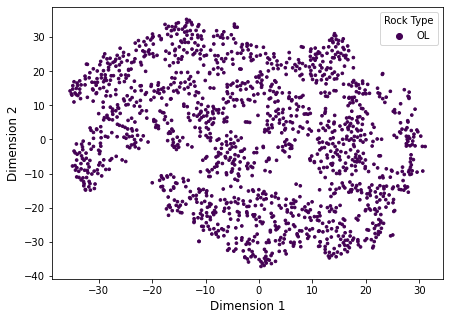

In [25]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==4),'TSNE_Rock_1'],
    dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==4),'TSNE_Rock_2'],
    c=dataframe_tot.loc[(dataframe_tot['Type']=='Test') & (dataframe_tot['Label']==4),'Label'].values,
    s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('OL')

plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)